# 4TIN811U Machine Learning & Deep Learning
# TP 6 (noté) - Régression logistique locale

## Régression logistique localement pondérée
Dans ce TP, vous allez combiner les idées de deux points de matière du cours : la **régression logistique**, et la **régression locale**. Le but va être d'obtenir une *version "locale" de la régression logistique*. Nous étudions donc un problème de classification binaire.

Nous vous demanderons au fil du TP d'implémenter vous-mêmes des fonctions permettant de résoudre ce problème (vous pouvez utiliser `numpy`, mais pas `scikit-learn`). 
***IMPORTANT :*** **Vous pouvez également partir de code déjà existant et le modifier, auquel cas il faut impérativement mentionner la source du code d'origine (même pour du code issu des corrections des TPs).**

Les fonctions que nous vous demandons d'implémenter et les questions auxquelles on vous demande de répondre sont un "minimum", mais vous pouvez bien sûr définir vos propres fonctions, rajouter des cases dans le notebook, ou rajouter des commentaires si vous le jugez utile. Si vous tombez à court de temps mais que tout ne fonctionne pas encore, n'hésitez pas à décrire où vous en êtes et ce qui, selon vous, pourrait être corrigé avec plus de temps.

Nous allons utiliser un sous-ensemble du dataset sur les pommes déjà utilisé au TP 2 ; celui-ci est fourni dans `tp6.zip` sur Moodle et s'appelle `dataset_tp6_apples.npy`. Comme d'habitude, on a $m$ données $x^{(i)}\in\mathbb{R}^n$ (où $n$ est le nombre de features), et une classification $y^{(i)}\in\{0, 1\}$ pour chacune de ces données. Ici, $m = 75$ et $n = 2$. Les deux features sont la taille et la *sweetness* des pommes ; une valeur $y^{(i)} = 1$ désigne une bonne pomme, et une valeur $y^{(i)} = 0$ désigne une mauvaise pomme. Les données sont déjà normalisées.

In [1]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 75 données, trois colonnes : taille, sweetness et qualité
apple_quality = np.load("dataset_tp6_apples.npy")
print(apple_quality.shape)
print(apple_quality.dtype)
print(apple_quality[0:10,:])

size = apple_quality[:,0]
sweetness = apple_quality[:,1]
quality = apple_quality[:,2]

(75, 3)
float64
[[-9.55123820e-02 -3.77058660e+00  0.00000000e+00]
 [ 1.27457587e+00 -5.12298651e-01  1.00000000e+00]
 [ 2.62695300e-03 -2.29095250e+00  0.00000000e+00]
 [ 1.09886229e+00  2.12028298e+00  1.00000000e+00]
 [-1.31845315e+00 -2.02188403e+00  1.00000000e+00]
 [ 2.88490961e+00 -3.05572548e-01  0.00000000e+00]
 [ 1.64132946e+00  1.39824817e+00  0.00000000e+00]
 [ 2.77424257e+00  4.80234344e-01  1.00000000e+00]
 [-5.05869555e-01  1.22833965e+00  1.00000000e+00]
 [ 3.60222986e+00 -6.07623597e-01  1.00000000e+00]]


Voici le graphique en 2D (une dimension par feature) reprenant les différentes données, en utilisant des symboles différents pour les bonnes et les mauvaises pommes.

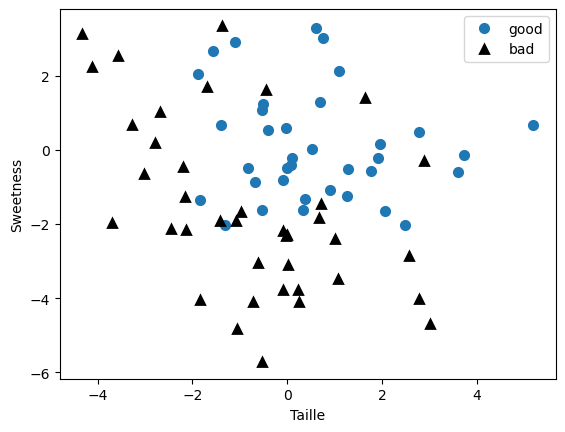

In [3]:
plt.figure()
good_idx = np.where(quality == 1)
bad_idx = np.where(quality == 0)
plt.plot(size[good_idx], sweetness[good_idx], "o", label="good", markeredgewidth=2)
plt.plot(size[bad_idx], sweetness[bad_idx], "^", label="bad", markeredgewidth=2, c="k")
plt.legend()
plt.xlabel("Taille")
plt.ylabel("Sweetness")
plt.show()

Nous allons chercher un vecteur $\theta\in\mathbb{R}^{n+1}$ maximisant la fonction de log-vraisemblance suivante pour un $x\in\mathbb{R}^{n+1}$ fixé ($\tau$ est un paramètre) :
$$\ell(\theta) = \left(\sum_{i = 1}^m w^{(i)} \left[y^{(i)}\log h_\theta(x^{(i)}) + (1 - y^{(i)})\log(1 - h_\theta(x^{(i)}))\right]\right) - \frac{\lambda}{2}\theta^T\theta,$$
où
$$h_\theta(x^{(i)}) = \frac{1}{1 + e^{-\theta^{T}x^{(i)}}}, \text{ et } w^{(i)} = \exp\left(-\frac{||x - x^{(i)}||^2}{2\tau^2}\right).$$
Le terme $-\frac{\lambda}{2}\theta^T\theta$ est un *paramètre de régularisation* utile pour que la méthode fonctionne bien ; considérez-le dans votre implémentation, mais ne vous inquiétez pas de son interprétation dans le TP. Vous pouvez fixer $\lambda = 0.0001$.

Hormis ce terme $-\frac{\lambda}{2}\theta^T\theta$, quel est le changement dans la formule de $\ell$ par rapport à la formule de log-vraisemblance pour la régression logistique classique (celle vue au cours) ? Quel est l'effet de ce changement ?

**(/1)** *Réponse* : Pour chaque $i\in\{1,\ldots,m\}$, on multiplie le terme correspondant à la donnée $x^{(i)}$ par un poids $w^{(i)}\in[0, 1]$. Cela a pour effet de donner plus d'importance aux données proches du point $x$ fixé.

À nouveau, les poids sont paramétrés par une *bande passante* $\tau$. À l'aide d'un ou plusieurs graphiques (avec un nombre de dimensions adapté à notre problème actuel), discutez d'une valeur raisonnable pour $\tau$.

In [4]:
from matplotlib import cm

# Fonction weight reprise du TP 2.
def weight(x, xi, tau):
    """Returns the weight to give xi from the training set
       with respect to a point x and with bandwidth tau."""
    diff = np.subtract(xi, x)
    return np.exp(- np.inner(diff, diff) / (2 * (tau ** 2)))

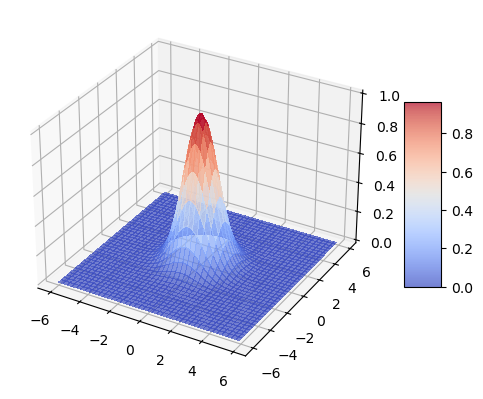

In [5]:
# Code pour le graphique inspiré du TP 5.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x = np.array([0., 0.])
tau = 1. # Plusieurs valeurs à essayer

# Les données varient entre -6 et 6
A = np.arange(-6, 6, .1)
B = np.arange(-6, 6, .1)
A, B = np.meshgrid(A, B)
f = lambda x1, x2: weight(x, [x1, x2], tau)
f_vect = np.vectorize(f)
Z = f_vect(A, B)

surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, alpha=.7,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()

**(/3)** *Réponse (quelle(s) valeur(s) de $\tau$ choisiriez-vous, et pourquoi ?)* : Au vu de la magnitude des données et du graphique, des valeurs de $\tau$ entre $0.5$ et $2$ semblent donner un poids non-négligeable à un voisinage raisonnable de points autour de $x$, tout en rendant négligeables les poids des points éloignés de $x$.

Le gradient de $\ell$ est donné par

$$\nabla_\theta \ell(\theta) = X^Tz - \lambda\theta,$$
où $z_i = w^{(i)}(y^{(i)} - h_\theta(x^{(i)}))$.

Pour un $\theta\in\mathbb{R}^{n+1}$, quelle est la taille du vecteur $\nabla_\theta \ell(\theta)$ ?

**(/1)** *Réponse* : $\nabla_\theta \ell(\theta) \in \mathbb{R}^{n+1}$. Aucune justification n'était demandée, mais il y a deux façons de le voir: $(i)$ une fonction de $\mathbb{R}^{n+1} \to \mathbb{R}$ a, par définition, un gradient qui est une fonction $\mathbb{R}^{n+1} \to \mathbb{R}^{n+1}$, $(ii)$ en regardant la formule donnée plus haut : $X^T \in \mathbb{R}^{(n+1) \times m}$, $z\in\mathbb{R}^m$, $\lambda\in\mathbb{R}$, et $\theta\in\mathbb{R}^{n+1}$.

**(/2)** Implémentez une fonction qui retourne le gradient de la fonction $\ell$ évaluée en un point $\theta$ par rapport à un point x.

In [6]:
lamb = 0.0001 # Paramètre lambda

def h(theta, x):
    return 1. / (1. + np.exp(-theta.T @ x))

def gradient_l(X, Y, theta, x, tau):
    z = np.array([weight(x, X[i], tau) * (Y[i] - h(theta, X[i])) for i in range(m)])
    return X.T @ z - lamb * theta

La matrice hessienne de $\ell$ est donnée par
$$ H_{\ell}(\theta) = X^TDX - \lambda I,$$
où $I$ est la matrice identité, et $D$ est la matrice diagonale telle que
$$
    D_{ii} = -w^{(i)}h_\theta(x^{(i)})(1 - h_\theta(x^{(i)})).
$$

Quelles sont les dimensions de la matrice $D$ et de la matrice hessienne $H_\ell$ ?

**(/1)** *Réponse* : $D\in\mathbb{R}^{m\times m}$ et $H_\ell(\theta) \in \mathbb{R}^{(n+1)\times (n+1)}$. Mêmes justifications possibles que pour le gradient : soit par définition de $\ell$ et de la matrice hessienne, soit en analysant la formule.

**(/2)** Implémentez une fonction qui retourne la matrice hessienne de $\ell$.

In [7]:
def xOneMinx(a):
    return a * (1 - a)

def hessian_l(X, theta, x, tau):
    diagonal_d = np.array([-weight(x, X[i], tau) * xOneMinx(h(theta, X[i])) for i in range(m)])
    D = np.diag(diagonal_d)
    return X.T @ D @ X - lamb * np.identity(n+1)

**(/1)** Donnez une implémentation de la méthode de Newton qui permettra (dans les cases suivantes du notebook) de trouver un maximum de la fonction $\ell$.

In [8]:
# Reprise de la correction du TP2.
def newton_multidim(f, df, theta, max_iter=1000, epsilon=1e-6):
    """Finds a root of multivariate function f given its gradient df and an initial guess theta_0.
       Assumes that a value theta is a root if np.linalg.norm(f(theta)) < epsilon.
       Raises an exception if no such value is found within max_iter iterations."""
    f_theta = f(theta)
    i = 0
    while np.linalg.norm(f_theta) > epsilon and i < max_iter:
        theta = theta - np.linalg.inv(df(theta)) @ f_theta
        f_theta = f(theta)
        i += 1
    if np.linalg.norm(f_theta) > epsilon and i >= max_iter:
        raise Exception("No root of f found in newton_multidim within the given number of iterations.")
    return theta

Veuillez classifier et afficher sur un graphique les résultats de votre implémentation pour de nombreux points de l'espace. Pour cette méthode, suffit-il de trouver un seul vecteur $(\theta_0, \theta_1, \theta_2)$ maximisant la log-vraisemblance et de tracer la frontière qui sépare les points classés $0$ et les points classés $1$ ? Pourquoi ?

**(/2)** *Réponse* : Toute la méthode et toutes les formules dépendent du point $x$ fixé pour lequel on veut une prédiction (en raison de la dépendance en $w^{(i)}$, qui prend ce point $x$ en paramètre et qui apparaît dans la fonction de log-vraisemblance). Il est donc nécessaire de réexécuter toute la méthode pour chacun des points $x$ pour lequel on veut une prédiction, comme c'était le cas pour la régression linéaire locale.

**(/5)** *Conseils pour l'affichage* : utilisez des couleurs différentes pour les prédictions et les données, et utilisez le paramètre `alpha` de la fonction `plt.plot` pour régler la transparence des prédictions (`alpha=.4` semble être une bonne valeur sur nos ordinateurs).

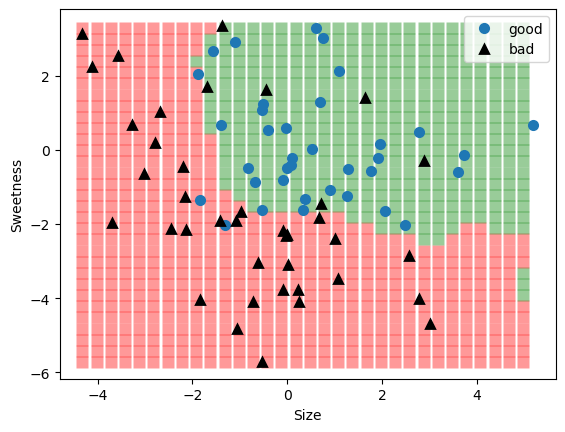

In [9]:
X = apple_quality[:, 0:2]
m, n = X.shape
X = np.concatenate((np.ones((m, 1)), X), axis=1)
Y = apple_quality[:, 2]

lamb = .0001
tau = 1

plt.figure()

to_evaluate_x1 = np.arange(np.min(X[:,1]), np.max(X[:,1]), .3)
to_evaluate_x2 = np.arange(np.min(X[:,2]), np.max(X[:,2]), .3)
for x1 in to_evaluate_x1:
    for x2 in to_evaluate_x2:
        x = np.array([1., x1, x2])
        gradient_l_theta = lambda theta: gradient_l(X, Y, theta, x, tau)
        hessian_l_theta = lambda theta: hessian_l(X, theta, x, tau)
        theta_max = newton_multidim(gradient_l_theta, hessian_l_theta, np.zeros((n+1)))
        prediction = h(theta_max, x)
        plt.plot(x1, x2, "s", c = "g" if prediction > .5 else "r", alpha=.4, ms=8, markeredgecolor='none')

good_idx = np.where(quality == 1)
bad_idx = np.where(quality == 0)
plt.plot(size[good_idx], sweetness[good_idx], "o", label="good", markeredgewidth=2)
plt.plot(size[bad_idx], sweetness[bad_idx], "^", label="bad", markeredgewidth=2, c="k")
plt.legend()
plt.xlabel("Size")
plt.ylabel("Sweetness")

plt.show()

*Ne répondez à la question suivante que si vos résultats jusqu'ici sont cohérents.*

Faites varier le paramètre $\tau$. Sur base de vos graphiques, comment interprétez-vous la variation du paramètre $\tau$ (par exemple, entre $0.1$ et $10$) ?

**(/2)** *Réponse* : Quand $\tau$ est grand (environ $> 5$), la méthode se rapproche de la régression logistique classique : on peut voir que la frontière entre les prédictions positives et négatives ressemble de plus en plus à une droite. Cela est dû au fait que tous les poids sont proches de $1$; quand tous les poids sont égaux à $1$, on retrouve exactement la régression logistique classique. Quand $\tau$ est petit (environ $< .2$), la méthode "overfit" : le voisinage de chaque point devient classifié comme le point lui-même ; la frontière ne ressemble plus du tout à une fonction linéaire, des "îlots" se créent autour de chaque donnée.